# Model performance

After training all SVMs, we assess model performance using precision and recall of both outcome classes.

### Importing packages

In [2]:
import datetime
from itertools import product
import pickle
from pyprojroot import here

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.metrics import precision_recall_curve, average_precision_score

### Setting Data Path

In [3]:
# data_path = here('data/')
results_path = here('results/')

### Functions to read files created by 2_modeltraining.py and to plot results

In [14]:
def pretty_results(filenames, filepath=results_path/'models/'):
    reslist = []
    for index1, filename in enumerate(filenames):
        _, sex, nback = filename.split('_')
        res = pd.read_pickle(filepath / f'{filename}.pkl')
        for index2, cr in enumerate(res):
            traintest = ['train', 'test'][index2 % 2]
            reslist.append([index1+1, traintest, sex, cr['1']['precision'], cr['1']['recall'], cr['1']['support'],
                            cr['0']['precision'], cr['0']['recall'], cr['0']['support']])
    res = pd.DataFrame(reslist).set_axis(['nback', 'traintest', 'sex', 'ok_precision', 'ok_recall', 'ok_support',
                                          'low_precision', 'low_recall', 'low_support'], axis=1)
    return(res)
    
def get_scores(res_df):
    res_df['old_defrate'] = res_df['low_support'] / (res_df['low_support'] + res_df['ok_support'])
    res_df['new_defrate'] = 1 - res_df['ok_precision']
    res_df['missed_dons'] = 1 - res_df['ok_recall']
    res_df['prevented_defs'] = res_df['low_recall']
    res_df['missed_per_prev'] = (res_df['ok_support'] - res_df['ok_recall'] * res_df['ok_support']) / (res_df['low_support'] - (1 - res_df['ok_precision']) * res_df['ok_support'])
    
    res_df['old_def_n'] = res_df['low_support']
    res_df['new_def_n'] = round((1 - res_df['ok_precision']) * res_df['ok_support'])
    res_df['old_don_n'] = res_df['ok_support']
    res_df['new_don_n'] = res_df['ok_recall'] * res_df['ok_support']
    
    return(res_df)
 
def plot_precision_recall(res_df, measure, ylim, ylab, save=False):
    pl_df = res_df.groupby(['sex', 'traintest'])

    fig, ax = plt.subplots(1, 2, figsize=(12, 4))

    for name, group in pl_df:
        y = 0 if name[0] == 'women' else 1
        off = -0.2 if name[1] == 'train' else 0.2
        hatch = '/' if name[1] == 'test' else ''
        ax[y].bar(group.nback + off, group[measure], label=name[1], width=0.4, edgecolor='black', hatch=hatch)
        ax[y].set_ylim(ylim)
        ax[y].set_xticks(group.nback)
        ax[y].set_xticklabels(['SVM-1','SVM-2','SVM-3','SVM-4','SVM-5'], size='large')
        ax[y].set_ylabel(ylab, size='large')

    legloc = 'upper right' if measure == 'low_precision' else 'lower right'
    legbox = (1, 1) if measure == 'low_precision' else (1, 0)
    ax[0].legend(labels=['train', 'test'], bbox_to_anchor=legbox, loc=legloc, title='Dataset')
    ax[1].legend(labels=['train', 'test'], bbox_to_anchor=legbox, loc=legloc, title='Dataset')

    ax[0].set_title('Women')
    ax[1].set_title('Men')

    fig.tight_layout()
    plt.set_cmap('tab20')

    if save:
        plot_path = results_path / 'plots_performance/'
        plot_path.mkdir(parents=True, exist_ok=True)
        plt.savefig(plot_path / f'{save}.png')

    plt.show()
    
def plot_precision_recall_comp(res_df, measure, ylim, ylab, save=False):
    pl_df = res_df.loc[res_df['traintest'] == 'test'].groupby(['sex', 'split'])

    fig, ax = plt.subplots(1, 2, figsize=(12, 4))

    for name, group in pl_df:
        y = 0 if name[0] == 'F' else 1
        off = -0.2 if name[1] == 'time' else 0.2
        hatch = '/' if name[1] == 'time' else ''
        colr = 'deepskyblue' if name[1] == 'time' else 'rebeccapurple'
        ax[y].bar(group.nback + off, group[measure], label=name[1], width=0.4, edgecolor='black', 
                  hatch=hatch, color=colr)
        ax[y].set_ylim(ylim)
        ax[y].set_xticks(group.nback)
        ax[y].set_xticklabels(['SVM-1','SVM-2','SVM-3','SVM-4','SVM-5'], size='large')
        ax[y].set_ylabel(ylab, size='large')

    legloc = 'upper right' if measure == 'low_precision' else 'lower right'
    legbox = (1, 1) if measure == 'low_precision' else (1, 0)
    ax[0].legend(labels=['time', 'random'], bbox_to_anchor=legbox, loc=legloc, title='Train/test \nsplit')
    ax[1].legend(labels=['time', 'random'], bbox_to_anchor=legbox, loc=legloc, title='Train/test \nsplit')

    ax[0].set_title('Women')
    ax[1].set_title('Men')

    fig.tight_layout()

    if save:
        plot_path = results_path / 'plots_performance/'
        plot_path.mkdir(parents=True, exist_ok=True)
        plt.savefig(plot_path / f'{save}.png')

    plt.show()

# Model performance of SVM using all predictor variables
## Precision and recall plots for both outcome classes
Note the zoomed-in y-axes for precision plots in order to see differences between models more clearly.

In [15]:
res_df = pretty_results([f'res_{sex}_{nback}' for sex in ['men','women'] for nback in range(1,6)], filepath=results_path / 'models/')
res_df = get_scores(res_df)

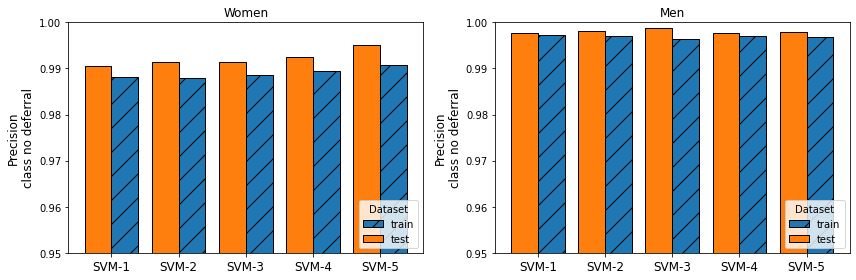

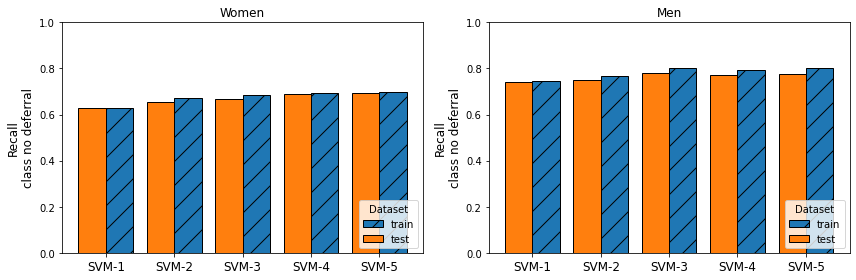

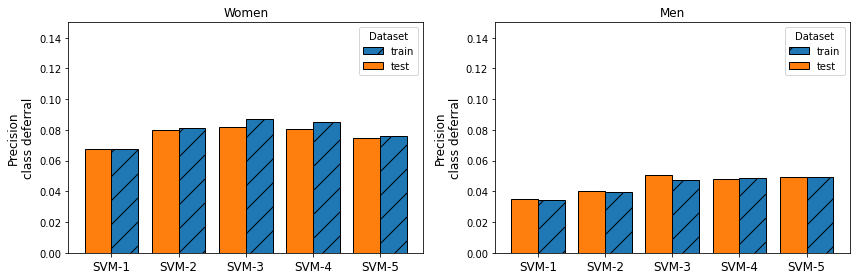

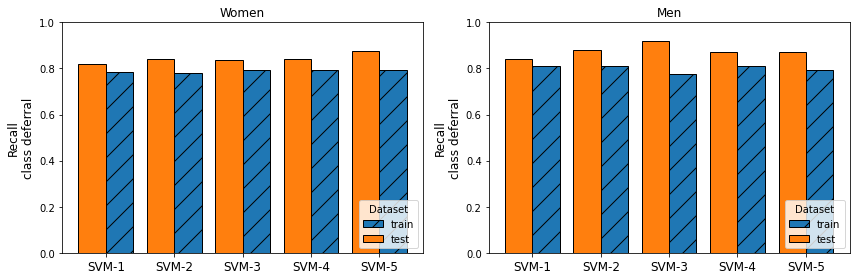

In [16]:
plot_precision_recall(res_df, 'ok_precision', (0.95, 1), 'Precision\nclass no deferral', save='all_ok_precision')
plot_precision_recall(res_df, 'ok_recall', (0, 1), 'Recall\nclass no deferral', save='all_ok_recall')
plot_precision_recall(res_df, 'low_precision', (0, 0.15), 'Precision\nclass deferral', 'all_low_precision')
plot_precision_recall(res_df, 'low_recall', (0, 1), 'Recall\nclass deferral', save='all_low_recall')

## Precision-recall curve
The PR curve shows the precision and recall at different probability thresholds for classification. This is more informative than a ROC curve because of the imbalanced outcome classes. A perfect classifier would have a precision of 1 for every recall value, so would look like a horizontal line at y=1. The area under the PR curve (AUPR) is a performance metric between 0 and 1 that indicates the quality of the classifier.  

### Functions to load probabilities and plot PR curves

In [33]:
def load_probas(sexes=('men', 'women'), path=results_path / 'probas/', nbacks=range(1, 6)):
    dfs = []
    for sex, nback in product(sexes, nbacks):
        df = pd.read_pickle(f'{path}/proba_{sex}_{nback}.pkl')
        df['sex'] = sex
        df['nback'] = nback
        dfs.append(df)
    return pd.concat(dfs)

def plot_prs(probas, save=False):
    fig, ax = plt.subplots(2, 2, figsize=(10,10))

    for x, sex in enumerate(['men', 'women']):
        df = probas.loc[probas['sex'] == sex, ]

        for key, group in df.groupby('nback'):
            precision_0, recall_0, thresholds_0 = precision_recall_curve(group.HbOK, group.prob_low, pos_label=0)
            precision_1, recall_1, thresholds_1 = precision_recall_curve(group.HbOK, group.prob_ok, pos_label=1)

            aupr_0 = round(average_precision_score(group.HbOK, group.prob_low, pos_label=0), 3)
            aupr_1 = round(average_precision_score(group.HbOK, group.prob_ok, pos_label=1), 3)

            ax[0, x].plot(recall_0, precision_0, label=f'SVM-{key}, AUPR: {aupr_0}')
            ax[1, x].plot(recall_1, precision_1, label=f'SVM-{key}, AUPR: {aupr_1}')

        ax[0,x].set_title('PR-curve class deferral - ' + ['men', 'women'][x])
        ax[0,x].set_xlabel('Recall')
        ax[0,x].set_ylabel('Precision')
        ax[1,x].set_title('PR-curve class no deferral - ' + ['men', 'women'][x])
        ax[1,x].set_xlabel('Recall')
        ax[1,x].set_ylabel('Precision')
        ax[0,x].legend(loc='upper right')
        ax[1,x].legend(loc='lower left')
        ax[0,x].set_ylim(0,0.5)

    #horizontal lines for baseline
    ax[0,0].hlines(y=def_m, xmin=0, xmax=1, color='grey', ls='--')
    ax[1,0].hlines(y=1-def_m, xmin=0, xmax=1, color='grey', ls='--')
    ax[0,1].hlines(y=def_f, xmin=0, xmax=1, color='grey', ls='--')
    ax[1,1].hlines(y=1-def_f, xmin=0, xmax=1, color='grey', ls='--')

    if save:
        plot_path = results_path / 'plots_performance/'
        plot_path.mkdir(parents=True, exist_ok=True)
        plt.savefig(plot_path / f'{save}.png')

    plt.show()

First, predictions are made on the test set again, now storing the probability of each observation belonging to each outcome class. We also calculate the proportion of observations belonging to each class (true outcome), as these are the baseline values for the AUPR (the AUPR obtained by a classifier predicting only the majority class).

In [18]:
from pathlib import Path
data_path = Path('X:/OneDrive/PhD/Data/202111 SVM Dutch data/')

In [25]:
sexes = ['men','women']
nbacks = range(1,6)
for sex, nback in product(sexes, nbacks):
    print(datetime.datetime.now(), 'Starting', nback, sex)
    
    clf = pickle.load(open(results_path / f'models/clf_{sex}_{nback}.sav', 'rb'))
    test = pd.read_pickle(data_path / f'scaled/{sex}_{nback}_test.pkl')
    y_true = test[test.columns[-1:]].copy()
    y_pred = clf.predict_proba(test[test.columns[:-1]])
    y_true[['prob_low', 'prob_ok']] = y_pred
    
    pickle.dump(y_true, open(results_path / f'proba_{sex}_{nback}.pkl', 'wb'))
    
proba_m = pd.read_pickle(results_path / 'probas/proba_men_1.pkl')
proba_f = pd.read_pickle(results_path / 'probas/proba_women_1.pkl')
def_m = 1-np.mean(proba_m.HbOK)
def_f = 1-np.mean(proba_f.HbOK)

2022-07-28 11:52:19.331073 Starting 1 men
2022-07-28 12:02:27.986840 Starting 2 men
2022-07-28 12:08:57.545147 Starting 3 men
2022-07-28 12:14:02.477980 Starting 4 men
2022-07-28 12:17:41.043222 Starting 5 men
2022-07-28 12:20:20.636083 Starting 1 women
2022-07-28 12:35:11.623783 Starting 2 women
2022-07-28 12:42:08.809031 Starting 3 women
2022-07-28 12:46:18.250252 Starting 4 women
2022-07-28 12:48:42.970938 Starting 5 women


### PR curve 
PR curves for men and women, shown for each of the 5 SVMs. AUPR values are given in the legend. The grey dashed line indicates the baseline.

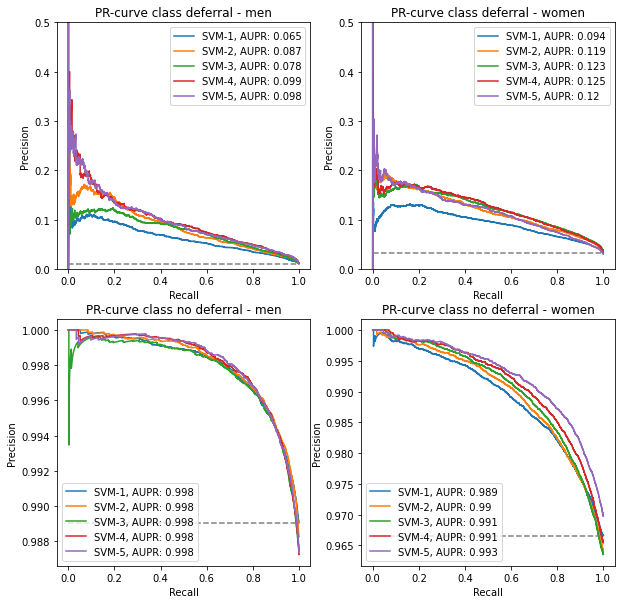

In [34]:
probas = load_probas()
plot_prs(probas, save='PR_curve')

## Actual and predicted deferral rates
There is a difference in deferral rate in the train and test sets. We calculate the difference in true deferral rate between the two sets, and the difference in predicted deferral rate by the model. We investigate the difference of these differences (column 'diffdiff') to see if the model captures these differences.

In [36]:
# Calculate predicted deferral rate per model
res_df['pred_def_n'] = res_df['ok_support'] - (res_df['ok_precision'] * res_df['ok_support']) + res_df['low_recall'] * res_df['low_support']
res_df['pred_defrate'] = res_df['pred_def_n'] / (res_df['ok_support'] + res_df['low_support'])
df_defrates = res_df[['nback', 'traintest', 'sex', 'old_defrate', 'pred_defrate']].copy()

defs = df_defrates.pivot(index=['nback', 'sex'], columns='traintest', values=['old_defrate', 'pred_defrate']).copy()
defs['old_defrate', 'diff'] = defs['old_defrate', 'test'] - defs['old_defrate', 'train']
defs['pred_defrate', 'diff'] = defs['pred_defrate', 'test'] - defs['pred_defrate', 'train']
defs['diffdiff'] = defs['pred_defrate', 'diff'] - defs['old_defrate', 'diff']
defs

old_defrate           pred_defrate           old_defrate  \
traintest          test     train         test     train        diff   
nback sex                                                              
1     men      0.010963  0.011011     0.011663  0.011614   -0.000049   
2     men      0.011757  0.011775     0.012428  0.012246   -0.000018   
3     men      0.012462  0.012563     0.013138  0.012841   -0.000100   
4     men      0.012761  0.013168     0.013376  0.013665   -0.000407   
5     men      0.012602  0.013040     0.013225  0.013513   -0.000438   
6     women    0.033409  0.031894     0.037579  0.035257    0.001515   
7     women    0.035947  0.034555     0.039675  0.037386    0.001391   
8     women    0.036479  0.034130     0.039836  0.036826    0.002350   
9     women    0.034597  0.031635     0.037662  0.033873    0.002962   
10    women    0.030275  0.027218     0.032905  0.028652    0.003057   

            pred_defrate  diffdiff  
traintest           diff            
nback sex                           
1     men       0.000049  0.000098  
2     men       0.000181  0.000199  
3     men       0.000297  0.000397  
4     men      -0.000289  0.000118  
5     men      -0.000288  0.000150  
6     women     0.002322  0.000807  
7     women     0.002290  0.000898  
8     women     0.003010  0.000660  
9     women     0.003789  0.000827  
10    women     0.004253  0.001196

In [37]:
print('The mean difference of the differences is {} percentage points, the maximum is {}.'.format(round(np.mean(defs['diffdiff']) * 100, 3),
                                                                                                  round(np.max(defs['diffdiff']) * 100, 3)))

The mean difference of the differences is 0.053 percentage points, the maximum is 0.12.


### Performance comparison with random train/test split

In [8]:
res_df_randomsplit = pretty_results(['res_1', 'res_2', 'res_3', 'res_4', 'res_5'], filepath='../results/models_randomsplit/')
res_df_randomsplit = get_scores(res_df_randomsplit)

In [9]:
res_df['split'] = 'time'
res_df_randomsplit['split'] = 'random'

res_tot = pd.concat([res_df, res_df_randomsplit])
res_tot.head()

,nback,trainval,sex,ok_precision,ok_recall,ok_support,low_precision,low_recall,low_support,old_defrate,new_defrate,missed_dons,prevented_defs,missed_per_prev,old_def_n,new_def_n,old_don_n,new_don_n,split
0,1,train,M,0.997628,0.741436,120264,0.034975,0.841673,1339,0.011011,0.002372,0.258564,0.841673,29.509947,1339,285.0,120264,89168.0,time
1,1,val,M,0.997173,0.747547,96715,0.034292,0.808769,1072,0.010963,0.002827,0.252453,0.808769,30.575606,1072,273.0,96715,72299.0,time
2,1,train,F,0.990522,0.627414,123754,0.067431,0.817758,4077,0.031894,0.009478,0.372586,0.817758,15.877762,4077,1173.0,123754,77645.0,time
3,1,val,F,0.988179,0.627488,105516,0.067717,0.782835,3647,0.033409,0.011821,0.372512,0.782835,16.379250,3647,1247.0,105516,66210.0,time
4,2,train,M,0.998071,0.751060,95091,0.040337,0.878199,1133,0.011775,0.001929,0.248940,0.878199,24.928026,1133,183.0,95091,71419.0,time


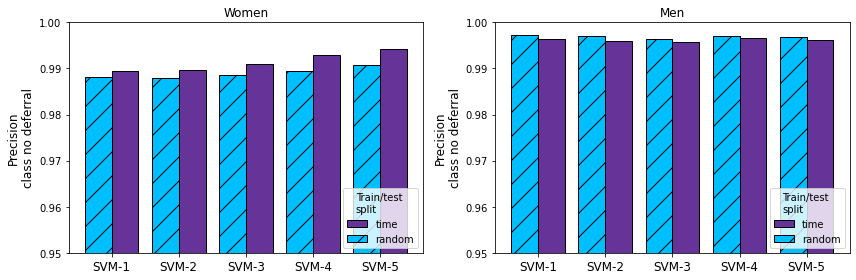

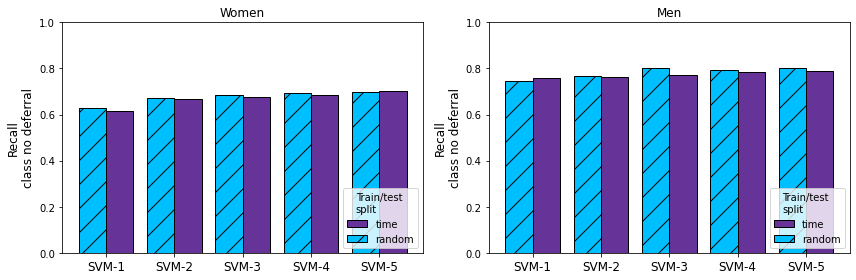

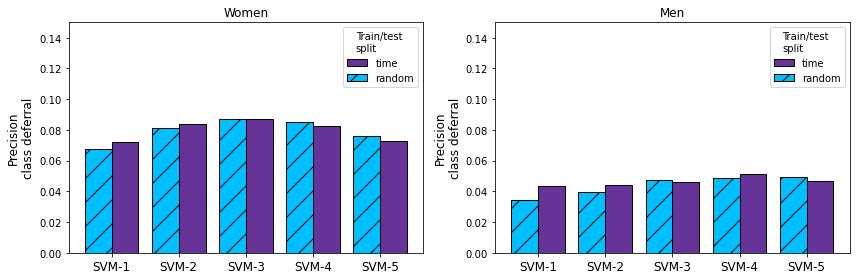

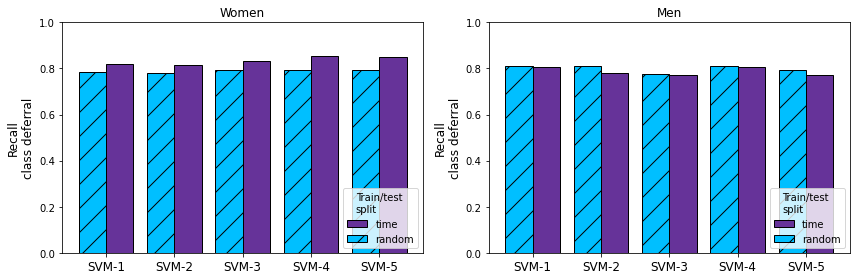

In [18]:
plot_precision_recall_comp(res_tot, 'ok_precision', (0.95, 1), 'Precision\nclass no deferral', save='comparesplits_ok_precision')
plot_precision_recall_comp(res_tot, 'ok_recall', (0, 1), 'Recall\nclass no deferral', save='comparesplits_ok_recall')
plot_precision_recall_comp(res_tot, 'low_precision', (0, 0.15), 'Precision\nclass deferral', save='comparesplits_low_precision')
plot_precision_recall_comp(res_tot, 'low_recall', (0, 1), 'Recall\nclass deferral', save='comparesplits_low_recall')

### Numerical comparison of performance for time/random split

In [14]:
comp_res = res_tot.loc[res_tot['trainval'] == 'val', 
                       ['nback', 'sex', 
                        'ok_precision', 'ok_recall',
                        'low_precision', 'low_recall', 
                        'split']].pivot(index=['nback', 'sex'], columns='split')

comp_res['ok_precision', 'diff'] = comp_res['ok_precision', 'time'] - comp_res['ok_precision', 'random']
comp_res['ok_recall', 'diff'] = comp_res['ok_recall', 'time'] - comp_res['ok_recall', 'random']
comp_res['low_precision', 'diff'] = comp_res['low_precision', 'time'] - comp_res['low_precision', 'random']
comp_res['low_recall', 'diff'] = comp_res['low_precision', 'time'] - comp_res['low_precision', 'random']

comp_res

ok_precision           ok_recall           low_precision            \
split           random      time    random      time        random      time   
nback sex                                                                      
1     F       0.989437  0.988179  0.613285  0.627488      0.071854  0.067717   
      M       0.996499  0.997173  0.756775  0.747547      0.043185  0.034292   
2     F       0.989598  0.987979  0.666344  0.670104      0.083691  0.081146   
      M       0.995965  0.997056  0.764335  0.767124      0.044175  0.039714   
3     F       0.990875  0.988662  0.678247  0.684857      0.086957  0.086937   
      M       0.995761  0.996505  0.772940  0.801473      0.046252  0.047083   
4     F       0.992981  0.989348  0.683867  0.694440      0.082427  0.084931   
      M       0.996525  0.996941  0.786632  0.794161      0.051348  0.048489   
5     F       0.994126  0.990807  0.701443  0.698486      0.072792  0.075830   
      M       0.996146  0.996739  0.790567  0.803946      0.046886  0.049142   

          low_recall           ok_precision ok_recall low_precision low_recall  
split         random      time         diff      diff          diff       diff  
nback sex                                                                       
1     F     0.820550  0.782835    -0.001257  0.014203     -0.004137  -0.004137  
      M     0.805031  0.808769     0.000673 -0.009228     -0.008893  -0.008893  
2     F     0.813121  0.781343    -0.001619  0.003760     -0.002545  -0.002545  
      M     0.778626  0.809572     0.001091  0.002788     -0.004461  -0.004461  
3     F     0.830688  0.792547    -0.002214  0.006610     -0.000020  -0.000020  
      M     0.769912  0.777283     0.000745  0.028533      0.000831   0.000831  
4     F     0.854545  0.791371    -0.003633  0.010572      0.002503   0.002503  
      M     0.808081  0.811486     0.000416  0.007529     -0.002859  -0.002859  
5     F     0.849741  0.792424    -0.003319 -0.002957      0.003038   0.003038  
      M     0.771084  0.793904     0.000593  0.013379      0.002256   0.002256